In [12]:
pip install torch rasterio matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import numpy as np
import tensorflow as tf
import rasterio
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import albumentations as A

# Configuration
DATA_DIR = "/kaggle/input/satellite-segmentation-data-handeled/data handeld the _/data"
IMAGE_DIR = '/kaggle/input/satellite-segmentation-data-handeled/data handeld the _/data/images'
MASK_DIR = '/kaggle/input/satellite-segmentation-data-handeled/data handeld the _/data/labels'
IMG_SIZE = 128
CHANNELS = 12
BATCH_SIZE = 16
NUM_SAMPLES = 306  # From 0 to 305

# 1. Data Preparation with Numerical Sorting --------------------------------
def get_sorted_pairs(image_dir, mask_dir):
    # Get and sort image paths numerically
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.endswith(".tif")],
        key=lambda x: int(os.path.splitext(x)[0])
    )[:NUM_SAMPLES]
    
    # Get and sort mask paths numerically
    mask_files = sorted(
        [f for f in os.listdir(mask_dir) if f.endswith(".png")],
        key=lambda x: int(os.path.splitext(x)[0])
    )[:NUM_SAMPLES]
    
    # Create full paths
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_files]
    
    # Verify numerical order
    for i in range(NUM_SAMPLES):
        img_num = os.path.splitext(os.path.basename(image_paths[i]))[0]
        mask_num = os.path.splitext(os.path.basename(mask_paths[i]))[0]
        assert img_num == mask_num == str(i), \
            f"Mismatch at index {i}: Image {img_num} vs Mask {mask_num}"
    
    return image_paths, mask_paths

# Get properly sorted paths
image_paths, mask_paths = get_sorted_pairs(IMAGE_DIR, MASK_DIR)

# 2. Data Loading & Preprocessing ---------------------------------------------
def load_image(path):
    """Load 12-channel TIFF image"""
    with rasterio.open(path) as src:
        img = src.read()  # (12, 128, 128)
    return np.transpose(img, (1, 2, 0))  # (128, 128, 12)

def load_mask(path):
    """Load and process normalized mask"""
    mask = np.array(Image.open(path))  # Load normalized mask [0, 1]
    mask = (mask * 255)  # Scale to [0, 255]
    mask = (mask > 127).astype(np.float32)  # Binarize
    return np.expand_dims(mask, axis=-1)  # (128, 128, 1)

# Rest of the code remains the same as previous version...
# [Include the WaterDataset class, compute_stats, water_unet, 
#  and training setup from previous code here]

# Verify first and last elements
print("First image:", os.path.basename(image_paths[3]))    # Should be 0.tif
print("First mask:", os.path.basename(mask_paths[3]))      # Should be 0.png
print("Last image:", os.path.basename(image_paths[-50]))    # Should be 305.tif
print("Last mask:", os.path.basename(mask_paths[-50]))      # Should be 305.png

First image: 3.tif
First mask: 3.png
Last image: 256.tif
Last mask: 256.png


In [14]:
class WaterDataset(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, mean, std, batch_size=16, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.mean = mean
        self.std = std
        self.batch_size = batch_size
        self.augment = augment
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.GaussianBlur(p=0.2),
        ])
        
    def __len__(self):
        return len(self.image_paths) // self.batch_size
    
    def __getitem__(self, idx):
        batch_images = []
        batch_masks = []
        
        indices = range(idx*self.batch_size, (idx+1)*self.batch_size)
        
        for i in indices:
            img = load_image(self.image_paths[i])
            mask = load_mask(self.mask_paths[i])
            
            # Normalize each channel
            img = (img - self.mean) / self.std
            
            # Augmentation
            if self.augment:
                augmented = self.aug(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            batch_images.append(img)
            batch_masks.append(mask)
        
        return np.array(batch_images), np.array(batch_masks)

In [15]:
train_img, val_img, train_mask, val_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)
def compute_stats(image_paths, eps=1e-7):
    """Compute per-channel mean and std with numerical stability."""
    sum_ = np.zeros(CHANNELS)
    sum_sq = np.zeros(CHANNELS)
    count = 0
    
    for path in image_paths:
        img = load_image(path)
        
        # Skip if image contains NaNs or invalid values
        if np.isnan(img).any() or np.isinf(img).any():
            print(f"Warning: Invalid values found in {path}, skipping...")
            continue
            
        sum_ += np.mean(img, axis=(0, 1))
        sum_sq += np.mean(img**2, axis=(0, 1))
        count += 1
    
    if count == 0:
        raise ValueError("No valid images found for computing statistics!")
    
    mean = sum_ / count
    variance = (sum_sq / count) - mean**2
    
    # Ensure non-negative variance with epsilon
    variance = np.maximum(variance, eps)
    
    std = np.sqrt(variance)
    
    print("Computed statistics:")
    print(f"Mean: {mean}")
    print(f"Std: {std}")
    
    return mean, std
mean, std = compute_stats(image_paths)

Computed statistics:
Mean: [ 396.46767291  494.62102873  822.31978453  973.67496126 2090.11099642
 1964.05056902 1351.27395331  102.73963041  141.80390641  300.74136253
   35.10253308    9.75332642]
Std: [3.16227766e-04 3.16227766e-04 3.16227766e-04 3.16227766e-04
 3.16227766e-04 3.16227766e-04 3.16227766e-04 3.16227766e-04
 3.16227766e-04 3.16227766e-04 2.01845246e+01 2.77583066e+01]


In [16]:
# Add after loading paths but before training  
print(f"Found {len(image_paths)} images and {len(mask_paths)} masks")

# Verify first 5 samples
for i in range(5):
    img = load_image(image_paths[i])
    mask = load_mask(mask_paths[i])
    
    print(f"\nSample {i+1}:")
    print(f"Image shape: {img.shape} | Range: {img.min():.2f}-{img.max():.2f}")
    print(f"Mask shape: {mask.shape} | Unique values: {np.unique(mask)}")
    
    # Check for NaNs
    if np.isnan(img).any() or np.isnan(mask).any():
        print("WARNING: NaNs detected in data!")

Found 306 images and 306 masks

Sample 1:
Image shape: (128, 128, 12) | Range: -28.00-4975.00
Mask shape: (128, 128, 1) | Unique values: [0. 1.]

Sample 2:
Image shape: (128, 128, 12) | Range: 0.00-6411.00
Mask shape: (128, 128, 1) | Unique values: [0. 1.]

Sample 3:
Image shape: (128, 128, 12) | Range: -533.00-4261.00
Mask shape: (128, 128, 1) | Unique values: [0. 1.]

Sample 4:
Image shape: (128, 128, 12) | Range: -144.00-5560.00
Mask shape: (128, 128, 1) | Unique values: [0. 1.]

Sample 5:
Image shape: (128, 128, 12) | Range: -216.00-5266.00
Mask shape: (128, 128, 1) | Unique values: [0. 1.]


In [17]:
# 4. U-Net Architecture -------------------------------------------------------
def water_unet(input_size=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    inputs = tf.keras.Input(input_size)
    
   # Encoder with BatchNorm
    c1 = tf.keras.layers.Conv2D(64, 3, padding="same")(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation("relu")(c1)
    c1 = tf.keras.layers.Conv2D(64, 3, padding="same")(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation("relu")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(64, 3, padding="same")(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation("relu")(c2)
    c2 = tf.keras.layers.Conv2D(64, 3, padding="same")(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation("relu")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    
    # Decoder
    u4 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c3)
    u4 = tf.keras.layers.concatenate([u4, c2])
    c4 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(u4)
    c4 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(c4)
    
    u5 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c4)
    u5 = tf.keras.layers.concatenate([u5, c1])
    c5 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(u5)
    c5 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(c5)
    
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(c5)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
# 5. Training Setup ------------------------------------------------------------
# Create data generators
train_gen = WaterDataset(train_img, train_mask, mean, std, 
                        batch_size=BATCH_SIZE, augment=True)
val_gen = WaterDataset(val_img, val_mask, mean, std, 
                      batch_size=BATCH_SIZE)

model = water_unet()

# Update model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryIoU(target_class_ids=[1], name='iou'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [19]:
# 6. Training & Evaluation -----------------------------------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 641ms/step - iou: 0.4022 - loss: 0.6317 - precision: 0.4335 - recall: 0.8694 - val_iou: 0.7194 - val_loss: 0.3656 - val_precision: 0.9027 - val_recall: 0.7799
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - iou: 0.5792 - loss: 0.3405 - precision: 0.9252 - recall: 0.6091 - val_iou: 0.7250 - val_loss: 0.3090 - val_precision: 0.8324 - val_recall: 0.8489
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - iou: 0.6364 - loss: 0.2665 - precision: 0.8800 - recall: 0.6972 - val_iou: 0.7368 - val_loss: 0.3042 - val_precision: 0.8454 - val_recall: 0.8516
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - iou: 0.6392 - loss: 0.2602 - precision: 0.8499 - recall: 0.7221 - val_iou: 0.7368 - val_loss: 0.3049 - val_precision: 0.8432 - val_recall: 0.8538
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - iou: 0.7064 - loss: 0.2231 - precision: 0.9118 - recall: 0.7570 - val_iou: 0.7461 - val_loss: 0.3098 - val_precision: 0.8632 - val_recall: 0.8461
Epoch 6/50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


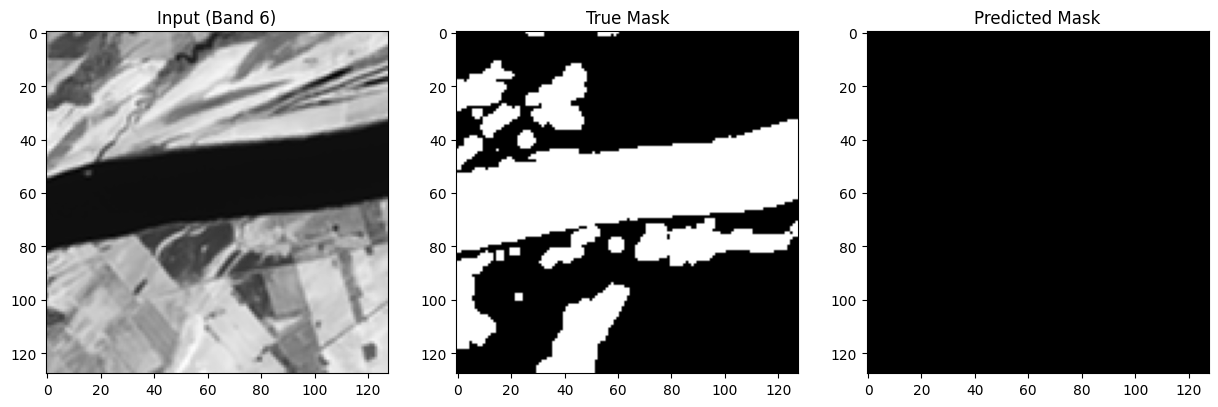

In [21]:
# 7. Visualization ------------------------------------------------------------
def plot_results(image, mask, prediction, band_idx=5):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[..., band_idx], cmap='gray')
    plt.title('Input (Band {})'.format(band_idx + 1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('True Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze() > 0.5, cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()

# Test prediction
sample_img = load_image(val_img[1])
sample_mask = load_mask(val_mask[1])
pred = model.predict(np.expand_dims(sample_img, axis=0))[0]
plot_results(sample_img, sample_mask, pred)